# Overview

This a notebook that 
1. inspects the results of a WarpX simulation
2. generates data files at different spatial locations, each file containing two columns: time sequence and field values
3. does fft of the field 

# Instruction

Enter the path of the data you wish to visualize below. Then execute the cells one by one, by selecting them with your mouse and typing `Shift + Enter`

In [40]:
# Import statements
import yt ; yt.funcs.mylog.setLevel(50)
import numpy as np
import scipy.constants as scc
from numpy import fft
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from matplotlib import rcParams
import math

### Define plotfile name

In [47]:
np.seterr(divide = 'ignore') 
diag_name = 'input' # E.g., diagnostics.diags_names = diag

### Initialize data files to be written in

In [48]:
# SET THIS
j0 = 0; j1 = 1; dj = 1 # starting j index j0; ending j index j1; interval dj; these are relative to the sampled region, not absolute coordinates
tn0 = 0; tn1 = 4001; dnt = 1 # starting t index tn0; ending t index tn1; interval dnt
dt = 2.16656e-16

for j in range(j0, j1, dj):
    filename = 'Ez_CPW_j%d.dat' %j
    f = open(filename, 'w') # writing mode
    np.savetxt(f, [])

### Save data into the data files using numpy 

In [49]:
for iteration in range (tn0, tn1, dnt) : # time step
    plotfile = '/global/cscratch1/sd/ajnonaka/palladium/diags/{}{:05d}'.format(diag_name, iteration)
    print(plotfile)
    ds = yt.load( plotfile ) # Load the plotfile
    # SET THIS
    # set left_edge to physical coordinates of lower-left corner
    # set dims to the number of cells to sample
    ad0 = ds.covering_grid(level=0, left_edge=[ -1.25e-7, 0, 0.], dims=[ 2, 2, 8])
    #ad0 = ds.covering_grid(level=0, left_edge=[ -1.25e-7, 4.7749999999999995e-05, 0.], dims=[ 2, 2, 8])
    Ez_array = ad0['Ez'].to_ndarray()
    #print(Ez_array)
    for j in range(j0, j1, dj):
        sum = 0
        k_start = 0
        k_end = 7
        for k in range(k_start, k_end+1, 1):
            sum = sum + Ez_array[0,j,k]
        sum = sum / (k_end-k_start+1)
        data = np.column_stack((dt * iteration, sum))
        filename = 'Ez_CPW_j%d.dat' %j
        f = open(filename, 'a') # writing mode
        np.savetxt(f, data)
        f.close()
        
ds.field_list # Print all available quantities

/global/cscratch1/sd/ajnonaka/palladium/diags/input00000


/global/u1/a/ajnonaka/CCSEPackages/yt/yt/data_objects/data_containers.py:1406: VisibleDeprecationWarning: The requested field name 'Ez' is ambiguous and corresponds to any one of the following field types:
 {'mesh'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("mesh", "Ez")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


/global/cscratch1/sd/ajnonaka/palladium/diags/input00001
/global/cscratch1/sd/ajnonaka/palladium/diags/input00002
/global/cscratch1/sd/ajnonaka/palladium/diags/input00003
/global/cscratch1/sd/ajnonaka/palladium/diags/input00004
/global/cscratch1/sd/ajnonaka/palladium/diags/input00005
/global/cscratch1/sd/ajnonaka/palladium/diags/input00006
/global/cscratch1/sd/ajnonaka/palladium/diags/input00007
/global/cscratch1/sd/ajnonaka/palladium/diags/input00008
/global/cscratch1/sd/ajnonaka/palladium/diags/input00009
/global/cscratch1/sd/ajnonaka/palladium/diags/input00010
/global/cscratch1/sd/ajnonaka/palladium/diags/input00011
/global/cscratch1/sd/ajnonaka/palladium/diags/input00012
/global/cscratch1/sd/ajnonaka/palladium/diags/input00013
/global/cscratch1/sd/ajnonaka/palladium/diags/input00014
/global/cscratch1/sd/ajnonaka/palladium/diags/input00015
/global/cscratch1/sd/ajnonaka/palladium/diags/input00016
/global/cscratch1/sd/ajnonaka/palladium/diags/input00017
/global/cscratch1/sd/ajnonaka/p

[('boxlib', 'Ez')]

### Read field from data files and plot field as a function time

4001
4001


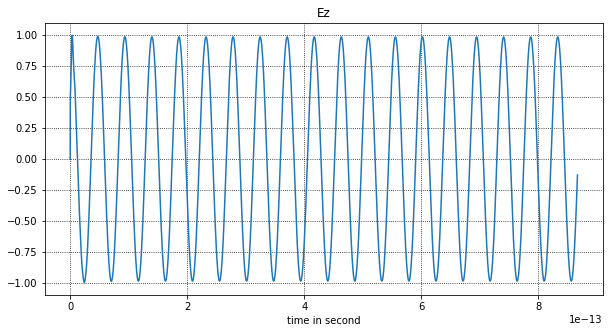

In [50]:
%matplotlib inline

rcParams['figure.figsize'] = 10, 5

for j in range(j0, j1, dj):
    data = np.loadtxt('./Ez_CPW_j%d.dat' %j) 
    nt = data[:, 0]
    Ez = data[:, 1]
    print(len(nt))
    print(len(Ez))
    plt.plot(nt, Ez)
    
plt.grid(True, color='k', linestyle=':')
plt.title("Ez")
plt.xlabel("time in second")
plt.show()

### FFT in time domain

In [51]:
#nt_scaled = math.floor((tn1-tn0)/dnt)    # Number of data points in input
nt_scaled = len(Ez)
dt_scaled = dt*dnt    # Sampling period (in seconds)

Ez_freq = fft.fft(Ez)/nt_scaled    # Fourier coefficients (divided by n)

#print(Ez_freq)
print(nt_scaled)
#print(dt_scaled)

freq = fft.fftfreq(nt_scaled,dt_scaled)  # Natural frequencies

Ez_freq = fft.fftshift(Ez_freq)   # Shift zero freq to center
freq = fft.fftshift(freq)   # Shift zero freq to center

print(len(Ez_freq))
print(len(freq))

#print(freq)


4001
4001
4001


### Plot frequency-domain field values

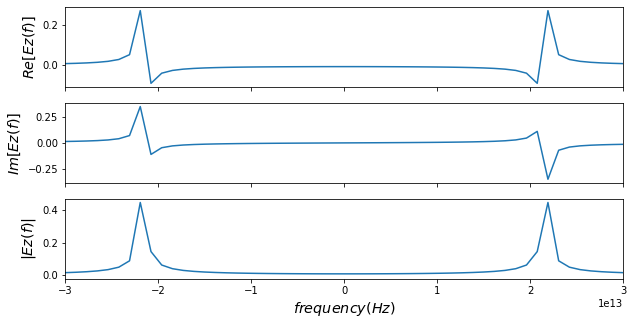

In [52]:
f, ax = plt.subplots(3,1,sharex=True)
ax[0].plot(freq, np.real(Ez_freq))         # Plot Cosine terms
ax[0].set_ylabel(r'$Re[Ez(f)]$', size = 'x-large')
ax[1].plot(freq, np.imag(Ez_freq))         # Plot Sine terms
ax[1].set_ylabel(r'$Im[Ez(f)]$', size = 'x-large')
ax[2].plot(freq, np.absolute(Ez_freq))  # Plot spectral power
ax[2].set_ylabel(r'$|Ez(f)|$', size = 'x-large')
ax[2].set_xlabel(r'$frequency(Hz)$', size = 'x-large')
plt.xlim((-3e13,3e13))
plt.show()